In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!gdown 1r8BvjiakPswIqnlZRYfRE47SgwYXLekB

Downloading...
From: https://drive.google.com/uc?id=1r8BvjiakPswIqnlZRYfRE47SgwYXLekB
To: /content/Flower.zip
100% 236M/236M [00:03<00:00, 67.3MB/s]


In [ ]:
!unzip Flower

Archive:  Flower.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: flo

In [ ]:
image_dir = Path('/content/flowers')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

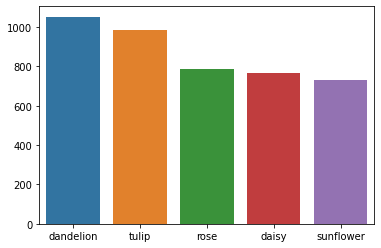

In [ ]:
sns.barplot(x=image_df.Label.value_counts().index, y=image_df.Label.value_counts().values)
plt.show()

In [ ]:
train_ds, test_ds = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)
test_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


##Train my own model

In [ ]:
def my_model(summary=False):
  input = layers.Input(shape=(224,224,3))

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(input)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  output = layers.Dense(5, activation='softmax')(x)

  model = Model(input, output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(model.summary())
    
  return model

In [ ]:
model_own = my_model(summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                             

In [ ]:
start_tra = perf_counter()
history = model_own.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 47s 289ms/step - loss: 2.4951 - accuracy: 0.3026 - val_loss: 1.6172 - val_accuracy: 0.2350
Epoch 2/20
108/108 [==============================] - 28s 254ms/step - loss: 1.3334 - accuracy: 0.4034 - val_loss: 1.9027 - val_accuracy: 0.2350
Epoch 3/20
108/108 [==============================] - 27s 250ms/step - loss: 1.2873 - accuracy: 0.4214 - val_loss: 1.9603 - val_accuracy: 0.2338
Epoch 4/20
108/108 [==============================] - 28s 258ms/step - loss: 1.2741 - accuracy: 0.4387 - val_loss: 1.8786 - val_accuracy: 0.2338
Epoch 5/20
108/108 [==============================] - 27s 254ms/step - loss: 1.2610 - accuracy: 0.4547 - val_loss: 1.7447 - val_accuracy: 0.2569
Epoch 6/20
108/108 [==============================] - 27s 253ms/step - loss: 1.2099 - accuracy: 0.4689 - val_loss: 2.0434 - val_accuracy: 0.2662
Epoch 7/20
108/108 [==============================] - 27s 253ms/step - loss: 1.1900 - accuracy: 0.4839 - val_loss: 1.8811 - val_ac

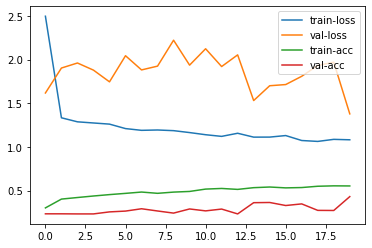

In [ ]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_own = model_own.evaluate(test_ds)[1]

27/27 [==============================] - 3s 116ms/step - loss: 1.3783 - accuracy: 0.4317


## TransferLearning Part 1 (Just change the last Dense layer--->to change the number of classes)

Notice that we can not use: vgg_model = VGG16(weights='imagenet',input_shape=(224,224,3), include_top=True, classes=10) because the model just accept imagenet weights when we don't change the number of its classes(1000); otherwise we should train the model on our dataset without imagenet weights and just use VGG's architecture (which is not useful beacuse of the time and low amount of data)

In [ ]:
# lest's first look at the complete VGG16 architecture
mobile_test = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)
mobile_test.summary()

14536120/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [ ]:
def Mobile_1(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [ ]:
mobile_1 = Mobile_1(summary=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
start_tra = perf_counter()
history_1 = mobile_1.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 148ms/step - loss: 0.7206 - accuracy: 0.7286 - val_loss: 0.4852 - val_accuracy: 0.8391
Epoch 2/20
108/108 [==============================] - 14s 134ms/step - loss: 0.3697 - accuracy: 0.8772 - val_loss: 0.4211 - val_accuracy: 0.8553
Epoch 3/20
108/108 [==============================] - 14s 134ms/step - loss: 0.3045 - accuracy: 0.9036 - val_loss: 0.3841 - val_accuracy: 0.8808
Epoch 4/20
108/108 [==============================] - 14s 133ms/step - loss: 0.2619 - accuracy: 0.9163 - val_loss: 0.3922 - val_accuracy: 0.8646
Epoch 5/20
108/108 [==============================] - 16s 145ms/step - loss: 0.2291 - accuracy: 0.9299 - val_loss: 0.3683 - val_accuracy: 0.8750
Epoch 6/20
108/108 [==============================] - 14s 133ms/step - loss: 0.2014 - accuracy: 0.9398 - val_loss: 0.3695 - val_accuracy: 0.8773
Epoch 7/20
108/108 [==============================] - 14s 133ms/step - loss: 0.1810 - accuracy: 0.9508 - val_loss: 0.3703 - val_ac

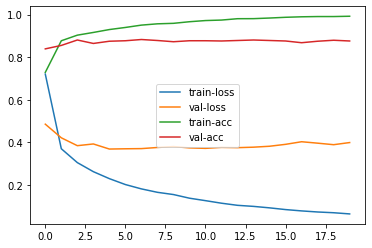

In [ ]:
plt.plot(history_1.history['loss'], label='train-loss')
plt.plot(history_1.history['val_loss'], label='val-loss')
plt.plot(history_1.history['accuracy'], label='train-acc')
plt.plot(history_1.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_mobile1 = mobile_1.evaluate(test_ds)[1]

27/27 [==============================] - 3s 112ms/step - loss: 0.3988 - accuracy: 0.8762


## TransferLearning Part 2 (Change the last Layer and add some dense/dropout layers too)

In [ ]:
def Mobile_2(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [ ]:
mobile_2 = Mobile_2(summary=True)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
start_tra = perf_counter()
history_2 = mobile_2.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 152ms/step - loss: 0.6324 - accuracy: 0.7892 - val_loss: 0.4486 - val_accuracy: 0.8322
Epoch 2/20
108/108 [==============================] - 16s 149ms/step - loss: 0.2497 - accuracy: 0.9128 - val_loss: 0.5786 - val_accuracy: 0.8183
Epoch 3/20
108/108 [==============================] - 15s 135ms/step - loss: 0.1645 - accuracy: 0.9409 - val_loss: 0.3883 - val_accuracy: 0.8889
Epoch 4/20
108/108 [==============================] - 15s 141ms/step - loss: 0.0979 - accuracy: 0.9684 - val_loss: 0.4575 - val_accuracy: 0.8681
Epoch 5/20
108/108 [==============================] - 14s 132ms/step - loss: 0.0622 - accuracy: 0.9783 - val_loss: 0.5165 - val_accuracy: 0.8738
Epoch 6/20
108/108 [==============================] - 14s 131ms/step - loss: 0.0562 - accuracy: 0.9809 - val_loss: 0.5576 - val_accuracy: 0.8634
Epoch 7/20
108/108 [==============================] - 14s 132ms/step - loss: 0.0448 - accuracy: 0.9838 - val_loss: 0.6194 - val_ac

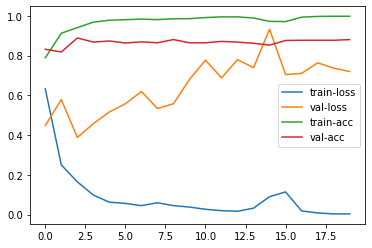

In [ ]:
plt.plot(history_2.history['loss'], label='train-loss')
plt.plot(history_2.history['val_loss'], label='val-loss')
plt.plot(history_2.history['accuracy'], label='train-acc')
plt.plot(history_2.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_mobile2 = mobile_2.evaluate(test_ds)[1]

27/27 [==============================] - 3s 108ms/step - loss: 0.7199 - accuracy: 0.8808


## TransferLearning Part 3 (Open the last trainable layers and add some dense/dropout layers)

In [ ]:
def Mobile_3(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # let the layers after last block anf fully connected layers be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  # last fully connected layer before Dense(1000) in image net
  output = output = mobile_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)
  mobile_model = Model(mobile_model.input, output)

  # mobile_model.get_layer('block5_conv3').trainable = True
  # mobile_model.get_layer('fc1').trainable = True
  # mobile_model.get_layer('fc2').trainable = True
  # mobile_model.get_layer('first_new_fc').trainable = True

  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [ ]:
mobile_3 = Mobile_3(summary=True)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
start_tra = perf_counter()
history_3 = mobile_3.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 141ms/step - loss: 0.5930 - accuracy: 0.8123 - val_loss: 0.4704 - val_accuracy: 0.8553
Epoch 2/20
108/108 [==============================] - 14s 133ms/step - loss: 0.2643 - accuracy: 0.9070 - val_loss: 0.6083 - val_accuracy: 0.8484
Epoch 3/20
108/108 [==============================] - 15s 141ms/step - loss: 0.1568 - accuracy: 0.9441 - val_loss: 0.7133 - val_accuracy: 0.8426
Epoch 4/20
108/108 [==============================] - 14s 134ms/step - loss: 0.1101 - accuracy: 0.9641 - val_loss: 0.5952 - val_accuracy: 0.8657
Epoch 5/20
108/108 [==============================] - 14s 134ms/step - loss: 0.0931 - accuracy: 0.9655 - val_loss: 0.6920 - val_accuracy: 0.8715
Epoch 6/20
108/108 [==============================] - 14s 133ms/step - loss: 0.0687 - accuracy: 0.9771 - val_loss: 0.8066 - val_accuracy: 0.8796
Epoch 7/20
108/108 [==============================] - 15s 143ms/step - loss: 0.0734 - accuracy: 0.9794 - val_loss: 0.6744 - val_ac

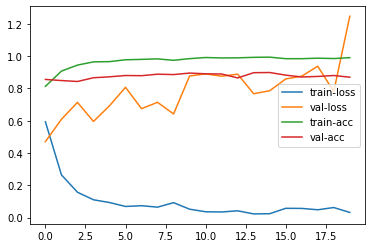

In [ ]:
plt.plot(history_3.history['loss'], label='train-loss')
plt.plot(history_3.history['val_loss'], label='val-loss')
plt.plot(history_3.history['accuracy'], label='train-acc')
plt.plot(history_3.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_mobile3 = mobile_3.evaluate(test_ds)[1]

27/27 [==============================] - 3s 105ms/step - loss: 1.2466 - accuracy: 0.8692


## TransterLearning Part 4 (Change Fully Connected Layers) 

In [ ]:
# lest's first look at the MobileNetV2 architecture without fully Connected 
mobile_test = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
mobile_test.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
def Mobile_4(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  output = mobile_model.layers[-1].output
  output = layers.GlobalAveragePooling2D(name='global_avg_2d')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [ ]:
mobile_4 = Mobile_4(summary=True)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
start_tra = perf_counter()
history_4 = mobile_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 20s 164ms/step - loss: 0.6185 - accuracy: 0.7831 - val_loss: 0.4063 - val_accuracy: 0.8438
Epoch 2/20
108/108 [==============================] - 15s 138ms/step - loss: 0.2628 - accuracy: 0.9062 - val_loss: 0.3953 - val_accuracy: 0.8600
Epoch 3/20
108/108 [==============================] - 14s 133ms/step - loss: 0.1395 - accuracy: 0.9508 - val_loss: 0.5063 - val_accuracy: 0.8565
Epoch 4/20
108/108 [==============================] - 14s 131ms/step - loss: 0.1003 - accuracy: 0.9658 - val_loss: 0.5069 - val_accuracy: 0.8576
Epoch 5/20
108/108 [==============================] - 17s 155ms/step - loss: 0.0704 - accuracy: 0.9763 - val_loss: 0.4838 - val_accuracy: 0.8843
Epoch 6/20
108/108 [==============================] - 15s 137ms/step - loss: 0.0694 - accuracy: 0.9774 - val_loss: 0.5097 - val_accuracy: 0.8819
Epoch 7/20
108/108 [==============================] - 14s 130ms/step - loss: 0.0446 - accuracy: 0.9844 - val_loss: 0.6153 - val_ac

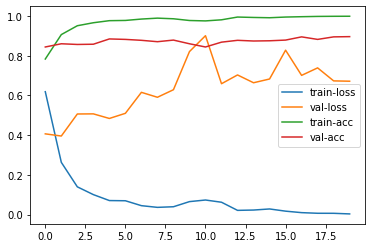

In [ ]:
plt.plot(history_4.history['loss'], label='train-loss')
plt.plot(history_4.history['val_loss'], label='val-loss')
plt.plot(history_4.history['accuracy'], label='train-acc')
plt.plot(history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_mobile4 = mobile_4.evaluate(test_ds)[1]

27/27 [==============================] - 3s 106ms/step - loss: 0.6714 - accuracy: 0.8958


In [ ]:
def anotherMobile_4(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  inputs = layers.Input(shape=(224,224,3))
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
another_mobile_4 = anotherMobile_4(summary=True)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_22 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0  

In [ ]:
start_tra = perf_counter()
another_history_4 = another_mobile_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 139ms/step - loss: 0.6231 - accuracy: 0.7857 - val_loss: 0.4726 - val_accuracy: 0.8322
Epoch 2/20
108/108 [==============================] - 14s 130ms/step - loss: 0.2573 - accuracy: 0.9056 - val_loss: 0.5015 - val_accuracy: 0.8449
Epoch 3/20
108/108 [==============================] - 14s 132ms/step - loss: 0.1433 - accuracy: 0.9540 - val_loss: 0.5288 - val_accuracy: 0.8692
Epoch 4/20
108/108 [==============================] - 15s 138ms/step - loss: 0.0880 - accuracy: 0.9667 - val_loss: 0.4624 - val_accuracy: 0.8785
Epoch 5/20
108/108 [==============================] - 14s 130ms/step - loss: 0.0634 - accuracy: 0.9777 - val_loss: 0.5590 - val_accuracy: 0.8553
Epoch 6/20
108/108 [==============================] - 14s 132ms/step - loss: 0.0680 - accuracy: 0.9760 - val_loss: 0.6644 - val_accuracy: 0.8600
Epoch 7/20
108/108 [==============================] - 14s 130ms/step - loss: 0.0733 - accuracy: 0.9728 - val_loss: 0.7069 - val_ac

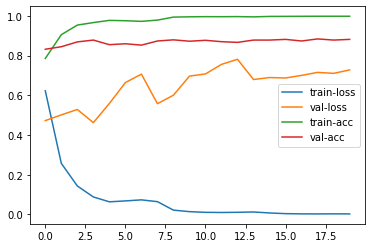

In [ ]:
plt.plot(another_history_4.history['loss'], label='train-loss')
plt.plot(another_history_4.history['val_loss'], label='val-loss')
plt.plot(another_history_4.history['accuracy'], label='train-acc')
plt.plot(another_history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
another_score_mobile4 = another_mobile_4.evaluate(test_ds)[1]

27/27 [==============================] - 3s 110ms/step - loss: 0.7280 - accuracy: 0.8819


## TransferLearinig Part 5 (Open the last trainable layers before fully connected and add some dense/dropout layers)

In [ ]:
def Mobile_5(summary=False):
  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in mobile_model.layers[:]:
      layer.trainable = False
  # this part is just like: mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  output = mobile_model.layers[-1].output
  output = layers.GlobalAveragePooling2D(name='glob_avg_2d')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  mobile_model = Model(mobile_model.input, output)
  mobile_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(mobile_model.summary())

  return mobile_model

In [ ]:
mobile_5 = Mobile_5(summary=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
start_tra = perf_counter()
history_5 = mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 18s 143ms/step - loss: 0.5977 - accuracy: 0.7999 - val_loss: 0.3935 - val_accuracy: 0.8773
Epoch 2/20
108/108 [==============================] - 15s 134ms/step - loss: 0.2475 - accuracy: 0.9166 - val_loss: 0.7512 - val_accuracy: 0.8090
Epoch 3/20
108/108 [==============================] - 15s 135ms/step - loss: 0.1561 - accuracy: 0.9464 - val_loss: 0.6643 - val_accuracy: 0.8634
Epoch 4/20
108/108 [==============================] - 14s 133ms/step - loss: 0.1306 - accuracy: 0.9551 - val_loss: 0.9199 - val_accuracy: 0.8218
Epoch 5/20
108/108 [==============================] - 14s 132ms/step - loss: 0.0949 - accuracy: 0.9644 - val_loss: 0.7390 - val_accuracy: 0.8738
Epoch 6/20
108/108 [==============================] - 15s 142ms/step - loss: 0.0667 - accuracy: 0.9771 - val_loss: 0.9367 - val_accuracy: 0.8611
Epoch 7/20
108/108 [==============================] - 15s 135ms/step - loss: 0.0805 - accuracy: 0.9765 - val_loss: 0.9954 - val_ac

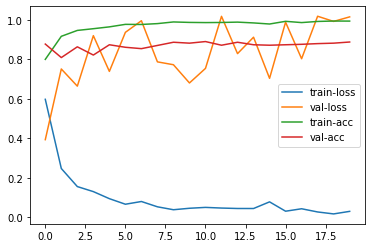

In [ ]:
plt.plot(history_5.history['loss'], label='train-loss')
plt.plot(history_5.history['val_loss'], label='val-loss')
plt.plot(history_5.history['accuracy'], label='train-acc')
plt.plot(history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_mobile5 = mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 109ms/step - loss: 1.0150 - accuracy: 0.8877


In [ ]:
def anotherMobile_5(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='Conv_1':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
another_mobile_5 = anotherMobile_5(summary=True)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_14  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_28 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_29 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0  

In [ ]:
start_tra = perf_counter()
another_history_5 = another_mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 144ms/step - loss: 1.4351 - accuracy: 0.4222 - val_loss: 1.0215 - val_accuracy: 0.6458
Epoch 2/20
108/108 [==============================] - 15s 136ms/step - loss: 0.9432 - accuracy: 0.6670 - val_loss: 0.7651 - val_accuracy: 0.7627
Epoch 3/20
108/108 [==============================] - 15s 140ms/step - loss: 0.7534 - accuracy: 0.7315 - val_loss: 0.6457 - val_accuracy: 0.7859
Epoch 4/20
108/108 [==============================] - 14s 134ms/step - loss: 0.6284 - accuracy: 0.7764 - val_loss: 0.5723 - val_accuracy: 0.8171
Epoch 5/20
108/108 [==============================] - 15s 138ms/step - loss: 0.5413 - accuracy: 0.8115 - val_loss: 0.5223 - val_accuracy: 0.8275
Epoch 6/20
108/108 [==============================] - 19s 180ms/step - loss: 0.4924 - accuracy: 0.8300 - val_loss: 0.4961 - val_accuracy: 0.8322
Epoch 7/20
108/108 [==============================] - 18s 168ms/step - loss: 0.4579 - accuracy: 0.8427 - val_loss: 0.4659 - val_ac

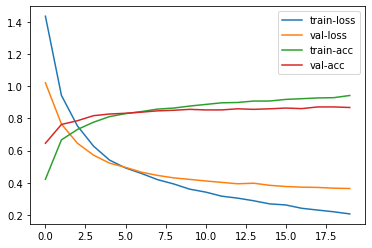

In [ ]:
plt.plot(another_history_5.history['loss'], label='train-loss')
plt.plot(another_history_5.history['val_loss'], label='val-loss')
plt.plot(another_history_5.history['accuracy'], label='train-acc')
plt.plot(another_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
another_score_mobile5 = another_mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 108ms/step - loss: 0.3648 - accuracy: 0.8681


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)])
mobile_preprocess = preprocess_input

In [ ]:
def lastMobile_5(summary=False):

  mobile_model = MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
  mobile_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in mobile_model.layers:
    if lyr.name=='block_6_expand':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = data_augmentation(inputs)
  x = mobile_preprocess(x)
  x = mobile_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-2),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
last_mobile_5 = lastMobile_5(summary=True)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0   

In [ ]:
start_tra = perf_counter()
last_history_5 = last_mobile_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 19s 155ms/step - loss: 2.4804 - accuracy: 0.7341 - val_loss: 0.5300 - val_accuracy: 0.8241
Epoch 2/20
108/108 [==============================] - 15s 135ms/step - loss: 0.4547 - accuracy: 0.8575 - val_loss: 0.5200 - val_accuracy: 0.8275
Epoch 3/20
108/108 [==============================] - 14s 133ms/step - loss: 0.3511 - accuracy: 0.8813 - val_loss: 0.5499 - val_accuracy: 0.8669
Epoch 4/20
108/108 [==============================] - 15s 135ms/step - loss: 0.2720 - accuracy: 0.9117 - val_loss: 0.4929 - val_accuracy: 0.8553
Epoch 5/20
108/108 [==============================] - 15s 143ms/step - loss: 0.2127 - accuracy: 0.9276 - val_loss: 0.5505 - val_accuracy: 0.8692
Epoch 6/20
108/108 [==============================] - 14s 133ms/step - loss: 0.2396 - accuracy: 0.9192 - val_loss: 0.5342 - val_accuracy: 0.8519
Epoch 7/20
108/108 [==============================] - 14s 133ms/step - loss: 0.1900 - accuracy: 0.9357 - val_loss: 1.2442 - val_ac

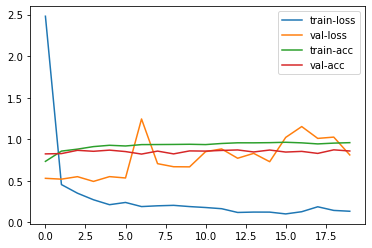

In [ ]:
plt.plot(last_history_5.history['loss'], label='train-loss')
plt.plot(last_history_5.history['val_loss'], label='val-loss')
plt.plot(last_history_5.history['accuracy'], label='train-acc')
plt.plot(last_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
last_score_mobile5 = last_mobile_5.evaluate(test_ds)[1]

27/27 [==============================] - 3s 106ms/step - loss: 0.8115 - accuracy: 0.8588
